In [1]:
#!pip install opencv-python

In [1]:
import os, glob, cv2, shutil, joblib,gc, random, re
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics
import random
import warnings
warnings.filterwarnings(action='ignore')
import datetime
print(datetime.datetime.today())

2022-11-07 10:45:15.017153


In [2]:
def video_gray2rgb(df):
    out=np.zeros(df.shape[:3]+(3,),dtype='u1')
    for i in range(df.shape[0]):
        img=cv2.cvtColor(df[i,:,:,0],cv2.COLOR_GRAY2RGB)
        out[i,:,:,:]=img   
        del img
    return out
def batch_avi(data,idx,BATCH_SIZE=1024,font=cv2.FONT_HERSHEY_SIMPLEX):
    def label_vis(data,i,font):
        input_img=cv2.cvtColor(data[i,:,:,0],cv2.COLOR_GRAY2RGB
                            ).astype('u1')
        
        pred_img=cv2.cvtColor(data[i,:,:,1]*255,cv2.COLOR_GRAY2RGB
                            ).astype('u1')
        pred_img[:,:,(0,2)]=0
        
        label_img=cv2.addWeighted(input_img,1,pred_img,.2,0)
        text=f"Index : {i}"
        cv2.putText(label_img,text, (80,30),font,1,(255,0,0),2)
        
        return np.expand_dims(label_img,axis=0)
    return np.concatenate([label_vis(data,i, font) 
                    for i in range((BATCH_SIZE*idx),
                                   (np.min([data.shape[0],(idx+1)*BATCH_SIZE])))])

def write_avi(data,file_name,fps=30):
    fourcc = cv2.VideoWriter_fourcc(*"DIVX")
    (width, height)=data.shape[1:3]
    out = cv2.VideoWriter(file_name, fourcc, fps, (height, width),isColor=True)
    for i in range(len(data)):
        out.write(data[i])
    out.release()
    
def my_confusion_matrix(y_true,y_pred,cutoff=.5):
    label_true=y_true>=.5
    pred_true=y_pred>=cutoff
    label_false= ~ label_true
    pred_false = ~ pred_true
    tp=np.sum(label_true&pred_true)
    fn=np.sum(label_true)-tp
    fp=np.sum(label_false&pred_true)
    tn=np.sum(label_false)-fp
    return tp,fn,fp,tn

# 모델링

In [3]:
files=glob.glob("/root/lustre/data/vHIT/s3/final/final_20221101_count/1.Dataset/**/**/seg/*.png")
model_files=np.array(sorted([i for i in files if re.compile('raw').findall(i)]))

In [4]:
def my_generator(files,shape=(240,320)):
    def img_load(file):
        try:
            try:
                img = cv2.imread(
                    f"/root/{os.path.realpath(file)}", cv2.IMREAD_COLOR)# 심볼릭 링크
            except:
                img = cv2.imread(
                    f"{os.path.realpath(file)}", cv2.IMREAD_COLOR)# 심볼릭 링크
            img = cv2.resize(img,shape[::-1])
        except:
            img = cv2.imread(file, cv2.IMREAD_COLOR)
            img = cv2.resize(img,shape[::-1])
        return img
    
    def generator():
        for file in files:
            split_img=img_load(file)#[np.newaxis]
            split_target_img=img_load(file.replace('raw','mask'))#[np.newaxis]
            yield split_img,split_target_img
    return generator

## 자료 확인

In [5]:
gen=my_generator(model_files)
x,y=next(iter(gen()))

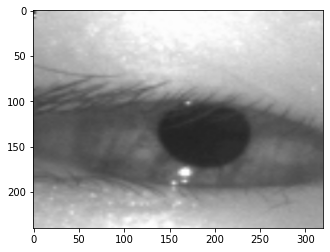

In [6]:
plt.imshow(x)

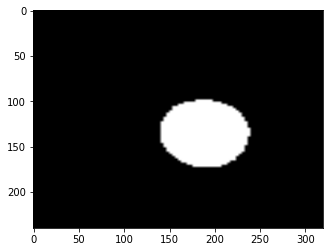

In [7]:
plt.imshow(y)

## 모델링 수행

In [8]:
kf = KFold(n_splits = 3, shuffle = False)
output_type='float32';output_shape=(240,320,3)

with tf.device('/device:GPU:0'):
    tf.keras.backend.clear_session()
    tf.random.set_seed(42)
    model=tf.keras.models.load_model(
        './DeepVOG.h5',compile=False)

tp_sum=dict();fn_sum=dict();fp_sum=dict();tn_sum=dict()


for K, (train_idx,test_idx) in enumerate(kf.split(model_files),1):    
    for cutoff in np.arange(0,1.1,0.05):
        cond=f"K_{K}_cutoff_{cutoff:.2f}"
        tp_sum[cond]=0;fn_sum[cond]=0;fp_sum[cond]=0;tn_sum[cond]=0
    train_files=model_files[train_idx]
    test_files=model_files[test_idx]
    train_files, valid_files=train_test_split(
        train_files, test_size=.2, random_state=42)
    train_files=sorted(train_files)
    valid_files=sorted(valid_files)
    test_files =sorted(test_files)
    
    random.seed(42)
    tr_dataset=tf.data.Dataset.from_generator(
        my_generator(train_files),
        output_shapes=(output_shape, output_shape),
        output_types=(output_type, output_type))
    random.seed(42)
    te_dataset=tf.data.Dataset.from_generator(
        my_generator(test_files),
        output_shapes=(output_shape, output_shape),
        output_types=(output_type, output_type))
    random.seed(42)
    val_dataset=tf.data.Dataset.from_generator(
        my_generator(valid_files),
        output_shapes=(output_shape, output_shape),
        output_types=(output_type, output_type))

    tr_gen =tr_dataset.shuffle(len(train_files)).batch(64).prefetch(1)
    te_gen =te_dataset.batch(1).prefetch(1)
    val_gen=val_dataset.batch(64).prefetch(1)

    print(f"K = {K}, test_length : {len(test_files)}")
    """
    모델 검증
    """
    for i,(x,y) in tqdm(enumerate(te_gen)):
        y_true=(cv2.cvtColor(
            y[0,:,:,:].numpy(),cv2.COLOR_RGB2GRAY)/255
               ).flatten().astype('int64')
        y_pred=model.predict(x/255)[0,:,:,1].flatten().astype('float64')
        for cutoff in np.arange(0,1.1,0.05):
            cond=f"K_{K}_cutoff_{cutoff:.02f}"
            tp,fn,fp,tn=my_confusion_matrix(y_true,y_pred,cutoff)
            # tn,fn,fp,tp=confusion_matrix(y_true,y_pred,cutoff=cutoff)
            tp_sum[cond]+=tp;fn_sum[cond]+=fn;fp_sum[cond]+=fp;tn_sum[cond]+=tn

2022-11-07 10:45:51.437418: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-07 10:45:52.081342: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46723 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:3b:00.0, compute capability: 8.6


K = 1, test_length : 1533


0it [00:00, ?it/s]2022-11-07 10:45:54.850837: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200
896it [01:14, 11.97it/s]


KeyboardInterrupt: 

In [11]:
# joblib.dump([tp_sum,fn_sum,fp_sum,tn_sum],'세그멘테이션지표.pkl')
from itertools import cycle
import matplotlib.pyplot as plt 
import numpy as np
import joblib
from sklearn import metrics
# tp_sum,fn_sum,fp_sum,tn_sum=joblib.load('세그멘테이션지표.pkl')

In [15]:
tpr=dict();fpr=dict();colors = cycle(["aqua", "darkorange", "cornflowerblue"])
roc_aucs=dict()
for K in range(1,4):
    tpr[K]=list();fpr[K]=list()    
    for i in np.arange(0,1.1,.05):
        tpr[K].append(tp_sum[f"K_{K}_cutoff_{i:.02f}"]/(
            tp_sum[f"K_{K}_cutoff_{i:.02f}"]+fn_sum[f"K_{K}_cutoff_{i:.02f}"]))
        fpr[K].append(fp_sum[f"K_{K}_cutoff_{i:.02f}"]/(
            fp_sum[f"K_{K}_cutoff_{i:.02f}"]+tn_sum[f"K_{K}_cutoff_{i:.02f}"]))
    tpr[K]=np.array(tpr[K]);fpr[K]=np.array(fpr[K])

for K,color in zip(range(1,4),colors):
    roc_auc=metrics.auc(fpr[K],tpr[K])
    roc_aucs[K]=roc_auc

In [16]:
np.mean(list(roc_aucs.values()))

0.9890063822937333

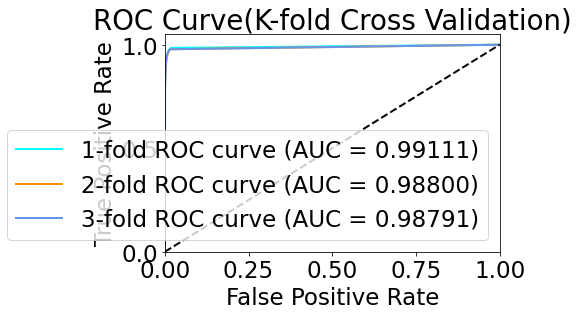

In [17]:
from itertools import cycle
plt.figure()
plt.rcParams['figure.figsize'] = [10,10]
plt.rcParams.update({'font.size': 23})
plt.figaspect(2)
colors = cycle(["aqua", "darkorange", "cornflowerblue"])
lw=2
for K,color in zip(range(1,4),colors):
    roc_auc=metrics.auc(fpr[K],tpr[K])
    plt.plot(
        fpr[K],
        tpr[K],
        label=f"{K}-fold ROC curve (AUC = {roc_auc:0.5f})",
        color=color,
        lw=lw
    )
plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve(K-fold Cross Validation)")
plt.legend(loc="lower right")
plt.show()